# Matrix Recovery

Matrix recovery is a technique used to fill in missing entries of a partially observed matrix. This has applications in areas like collaborative filtering (e.g., recommendation systems), image inpainting, and sensor networks where only partial data may be available.

In this section, we will use three different techniques to perform matrix recovery on a user-item rating matrix (e.g., a movie recommendation matrix with missing values):

Each technique has unique strengths:

- **SVD (Singular Value Decomposition)**: SVD is efficient for low-rank matrix approximation and works well when the underlying data has a low-rank structure. By keeping only the largest singular values, SVD helps to capture the main patterns in the data and is particularly effective when the matrix has a dominant low-rank component.

- **Nuclear Norm Minimization**: This approach is more robust in promoting low-rank properties, as it directly minimizes the nuclear norm (sum of singular values), which is a convex relaxation for rank minimization. It is commonly used in convex optimization for low-rank matrix recovery tasks and often produces accurate reconstructions when the low-rank assumption holds.

- **$( \boldsymbol{ \ell_1 } )$-norm Minimization**: Ideal for sparse matrices, $( \ell_1 )$-norm minimization encourages sparsity by minimizing the sum of absolute values of the matrix entries. This technique is effective in cases where only a few entries are non-zero, making it suitable for highly sparse data.

Each method approaches the problem of matrix recovery differently:
- **SVD** is effective for capturing low-rank structure efficiently.
- **Nuclear Norm Minimization** enforces low-rank constraints rigorously via convex optimization.
- **$( \boldsymbol{ \ell_1 } )$-norm Minimization** is optimal for cases where sparsity (rather than low rank) is the primary assumption.

In [41]:
import numpy as np

# Initial matrix with missing values
M = np.array([
    [5, 3, np.nan, 1],
    [4, np.nan, np.nan, 1],
    [1, 1, np.nan, 5],
    [1, np.nan, 4, 4],
    [np.nan, 1, 5, 4],
    [np.nan, 1, 5, 4]
])

## Matrix Recovery with SVD

In this approach, we will use **Singular Value Decomposition (SVD)** for matrix recovery, a common technique when the data matrix is assumed to have a low-rank structure.

### SVD Overview
SVD decomposes a matrix $( M )$ into three matrices:
$$[
M = U \Sigma V^T
]$$
where:
- $( U $) and $( V )$ are orthogonal matrices representing the left and right singular vectors.
- $( \Sigma )$ is a diagonal matrix containing singular values, which represent the significance of each component in explaining the variance in $( M )$.

By retaining only the largest singular values (up to a specified rank), we can reconstruct a low-rank approximation of the matrix, which helps recover missing entries based on underlying patterns in the data.

### Steps in SVD-Based Matrix Recovery
1. **Initial Guess**: Replace missing values with initial estimates, such as the mean of each column.
2. **Iterative SVD**: In each iteration, perform SVD, keep only the top `k` singular values, and reconstruct the matrix.
3. **Constrain Known Values**: After each reconstruction, replace the known values with their original values to maintain consistency with observed entries.

This iterative process gradually fills in the missing values while promoting a low-rank structure in the completed matrix.


In [26]:
from sklearn.impute import SimpleImputer
import numpy as np

# Replace NaNs with column mean for initial guess
imputer = SimpleImputer(strategy="mean")
imputer.fit(M)
M_imputed = imputer.transform(M)

# Iteratively apply SVD for matrix completion
rank = 2 # Assume low-rank structure
for i in range(10):  # Set a reasonable number of iterations
    # Perform SVD
    U, S, Vt = np.linalg.svd(M_approx, full_matrices=False)
    # Keep only the top `rank` singular values
    S = np.diag(S[:rank])
    U = U[:, :rank]
    Vt = Vt[:rank, :]
    # Reconstruct the matrix
    M_approx = U @ S @ Vt
    # Refill known values with original data to retain constraints
    M_approx[np.isnan(M) == False] = M[np.isnan(M) == False]

# M_approx[np.isnan(M) == False] = M[np.isnan(M) == False]
print("Completed Matrix using Iterative SVD:\n", M_approx)


Completed Matrix using Iterative SVD:
 [[5.         3.         4.74736048 1.        ]
 [4.         1.09955753 3.55445483 1.        ]
 [1.         1.         4.33397168 5.        ]
 [1.         1.18879643 4.         4.        ]
 [3.40149463 1.         5.         4.        ]
 [3.40149463 1.         5.         4.        ]]


In [ ]:
!pip install cvxpy

## Nuclear Norm Minimization

This method minimizes the nuclear norm (sum of singular values) of the matrix, which encourages a low-rank solution. This approach is a convex relaxation for rank minimization.

In [47]:
import cvxpy as cp

M[np.isnan(M)] = 0
mask = (M != 0)

# Define variables
M1 = M
M1[M==0] = np.random.rand(np.sum(M==0))
X = cp.Variable(M1.shape)
# Define nuclear norm objective with observed entries constraint
objective = cp.Minimize(cp.normNuc(X))
constraints = [cp.multiply(mask, X) == M]

# Solve the problem
prob = cp.Problem(objective, constraints)
prob.solve()

# Resulting completed matrix
completed_matrix = X.value
print("Completed Matrix using Nuclear Norm Minimization:\n", completed_matrix)


Completed Matrix using Nuclear Norm Minimization:
 [[4.99999994 3.00000004 0.00996626 0.99999998]
 [4.00000001 0.15294465 0.79559137 0.99999999]
 [0.99999998 0.99999999 0.38170042 5.00000002]
 [1.         0.75442466 3.99999998 3.99999997]
 [0.10915574 1.00000001 4.99999998 3.99999996]
 [0.24350024 1.00000001 4.99999998 3.99999996]]


## $\boldsymbol{ \ell_1 }$ Norm Minimization
If we expect the matrix to be sparse, we can use $( \ell_1 )$-norm minimization to promote sparsity in the recovered matrix. This approach is useful when we assume that most entries are zeros, and only a few interactions are non-zero. 

In [28]:
import numpy as np
import cvxpy as cp

# Define the variables
X = cp.Variable(M.shape)
mask = (M != 0)  # Boolean mask for known entries

# Define the objective function and constraints
objective = cp.Minimize(cp.norm(X, 1))
constraints = [cp.multiply(mask, X) == M]  # Enforce known entries

# Solve the optimization problem
prob = cp.Problem(objective, constraints)
prob.solve()

# Print the completed matrix
completed_matrix = X.value
print("Completed Matrix using L1 minimization:\n", completed_matrix)


Completed Matrix using L1 minimization:
 [[ 5.00000000e+00  3.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 4.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  0.00000000e+00  5.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  4.00000000e+00  4.00000000e+00]
 [-4.80644502e-15  1.00000000e+00  5.00000000e+00  4.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  5.00000000e+00  4.00000000e+00]]


# Video Background Removal

In this part, we will use **Singular Value Decomposition (SVD)** to separate the background from the foreground in a video. Background removal is a common task in computer vision, where the goal is to isolate moving objects (foreground) from the stationary or slowly changing background.

### Approach: Low-Rank Approximation with SVD

In a video, the background tends to remain relatively constant across frames, while the foreground (moving objects) changes over time. We can leverage this by treating each frame as a high-dimensional vector and stacking them into a matrix. By applying **SVD** to this matrix, we can approximate the background as a low-rank component, as it represents the largest sources of variance.

1. **Load and Flatten Frames**: Each video frame is converted to grayscale and flattened into a 1D vector. These vectors are stacked to form a matrix where each column represents a frame.
2. **Low-Rank Approximation using SVD**: SVD is applied to this matrix to efficiently compute the background, represented by the first few principal components.
3. **Background Removal**: By reconstructing the low-rank background and subtracting it from the original frames, we can isolate the foreground, highlighting the moving objects in each frame.

### Hint: Randomized SVD?
Randomized SVD is an efficient technique for computing low-rank approximations, especially useful for large datasets like video frames. By focusing only on the principal components, we reduce computation time while still capturing the main structure of the background.

[Referance](https://github.com/momonala/image-processing-projects/blob/master/background_removal/Singular_Value_Decomposition.ipynb)

Frame matrix shape: (76800, 794)
Original frame shape: (320, 240)


<function matplotlib.pyplot.show(close=None, block=None)>

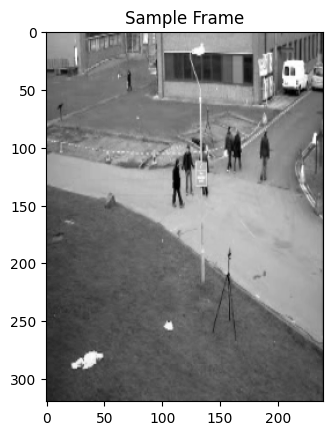

In [48]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


# Function to read frames from a video or a directory of images, with frame skipping
def load_video_frames(video_path, max_frames=100, frame_step=1):
    frames = []
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    total_frames_read = 0
    
    while total_frames_read < max_frames:
        # Read the frame
        ret, frame = cap.read()
        if not ret:
            break

        # Only process the frame if it is part of the frame_step
        if frame_count % frame_step == 0:
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            gray_frame = cv2.resize(gray_frame, np.array(gray_frame.shape))
            frames.append(gray_frame.flatten())  # Flatten each frame into a 1D vector
            total_frames_read += 1  # Update the count of processed frames
        
        frame_count += 1  # Update the count of total frames checked
    
    cap.release()
    return np.array(frames).T, gray_frame.shape  # Return frames and shape of single frame

# Example usage:
video_path = "vid.avi"  # Replace with your video path
frame_matrix, frame_shape = load_video_frames(video_path, max_frames=10000, frame_step=1)
print("Frame matrix shape:", frame_matrix.shape)  # Each column is a flattened frame
print("Original frame shape:", frame_shape)  # Shape of individual grayscale frame

plt.imshow(frame_matrix[:, 100].reshape(frame_shape), cmap="gray")
plt.title("Sample Frame")
plt.show

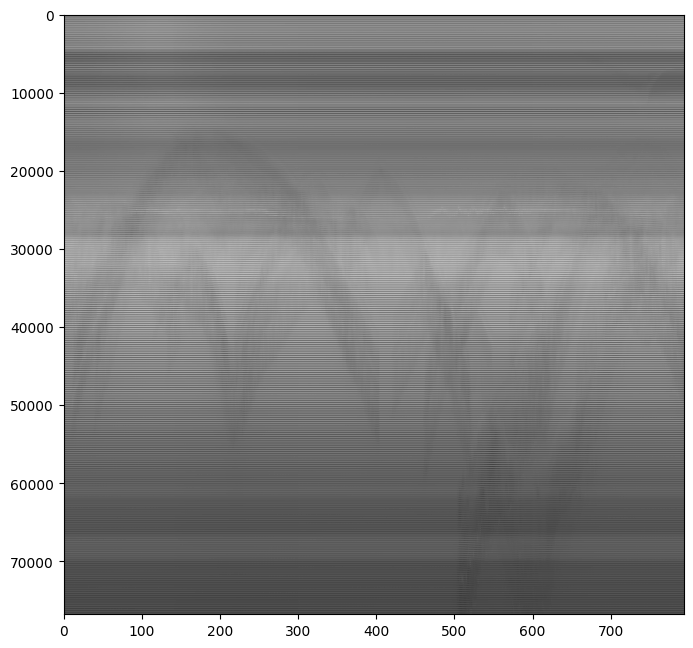

In [50]:
plt.figure(figsize=(8, 12))
plt.imshow(frame_matrix, aspect=.01, cmap='gray')
plt.show()

What is this?!!

(76800, 1) (1,) (1, 794)


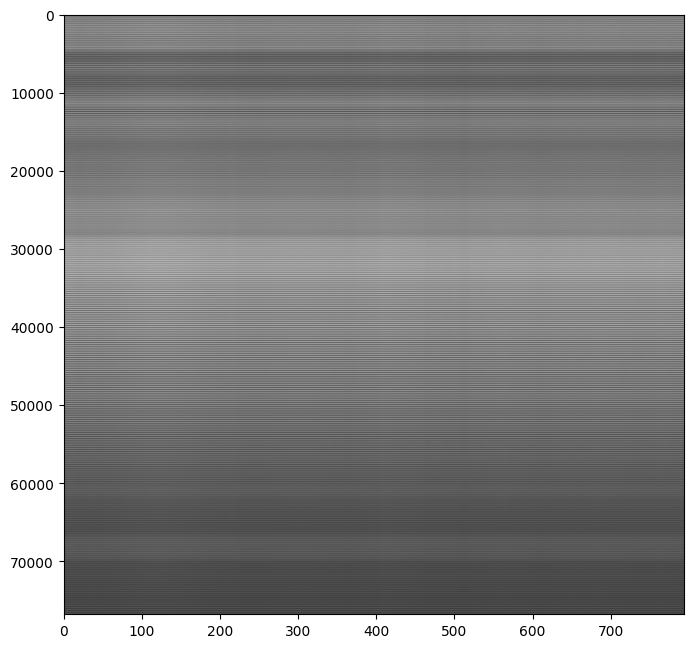

In [57]:
from sklearn.utils.extmath import randomized_svd

U, S, Vt = randomized_svd(frame_matrix, 1)
print (U.shape, S.shape, Vt.shape)

low_rank = U @ np.diag(S) @ Vt
low_rank.shape

plt.figure(figsize=(8, 12))
plt.imshow(low_rank, aspect=0.01, cmap='gray')

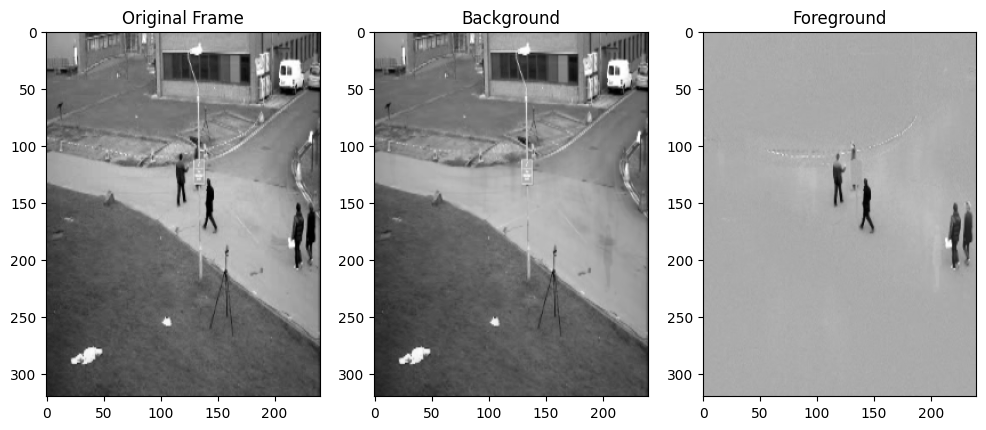

In [58]:
SVD_bg_removed = frame_matrix-low_rank

plt.figure(figsize=(12, 10))

# Display a sample original frame
plt.subplot(1, 3, 1)
plt.imshow(frame_matrix[:, 20].reshape(frame_shape), cmap="gray")
plt.title("Original Frame")

# Display the reconstructed background frame
plt.subplot(1, 3, 2)
plt.imshow(low_rank[:,20].reshape(frame_shape), cmap="gray")
plt.title("Background")

# Display the extracted foreground frame
plt.subplot(1, 3, 3)
plt.imshow(SVD_bg_removed[:,20].reshape(frame_shape), cmap="gray")
plt.title("Foreground")

plt.show()

In [59]:
import cv2

for i in range(SVD_bg_removed.shape[1]):
    # Scale foreground to the 0-255 range for visibility
    # foreground_frame = np.clip(SVD_bg_removed[:, i], 0, 255).astype(np.uint8).reshape(frame_shape)
    foreground_frame = SVD_bg_removed[:, i].astype(np.uint8).reshape(frame_shape)
    foreground_frame[(foreground_frame<45) | (foreground_frame>=200)] = 0
    background_frame = np.clip(low_rank[:, i], 0, 255).astype(np.uint8).reshape(frame_shape)

    # Combine background and foreground side-by-side
    combined_frame = np.hstack((background_frame, foreground_frame))

    # Display the frame
    cv2.imshow('Background Subtraction Result', combined_frame)
    if cv2.waitKey(5) & 0xFF == ord('q'):
            break
    
cv2.destroyAllWindows()


2024-11-07 11:27:37.796 Python[95156:12464546] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-07 11:27:37.796 Python[95156:12464546] +[IMKInputSession subclass]: chose IMKInputSession_Modern
